In [1]:
import simpy
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [3]:
def get_service_time(distribution_type):
    """Generate service time based on the distribution type."""
    if distribution_type == 'deterministic':
        # M/D/n
        return 1 / SERVICE_RATE  
    
    elif distribution_type == 'exponential':
        # M/M/n
        return np.random.exponential(1 / SERVICE_RATE)
    
    elif distribution_type == 'hyperexponential':
        # Service time distribution with long tail
        if np.random.rand() < 0.75:
            return np.random.exponential(1.0)
        else:
            return np.random.exponential(5.0)
    else:
        raise ValueError(f"Unknown distribution type: {distribution_type}")
    

def customer(env, name, server, arrival_rate, wait_times, priority, service_time_distribution):
    """Customer process: arrives, waits in queue, and gets served."""
    arrival_time = env.now
    service_time = get_service_time(service_time_distribution)
    
    if priority:
        with server.request(priority=service_time) as request:
            yield request  # Wait for a free server
            wait_time = env.now - arrival_time
            wait_times.append(wait_time)
            yield env.timeout(service_time)  # Time spent being served

    else:
        with server.request() as request:
            yield request  # Wait for a free server
            wait_time = env.now - arrival_time 
            wait_times.append(wait_time) 
            yield env.timeout(service_time)  # Time spent being served

def arrival_generator(env, server, arrival_rate, wait_times, priority, service_time_distribution):
    """Generate customers arriving at a random Poisson distributed interval with lambda = arrival_rate."""
    while True:
        yield env.timeout(np.random.exponential(1 / arrival_rate))
        env.process(customer(env, f"Customer-{env.now}", server, arrival_rate, wait_times, priority, service_time_distribution))

def simulate(n_servers, arrival_rate, sim_time, priority, service_time_distribution='exponential'):
    """Simulate an M/M/n or M/D/n queue
    Args:
    n_servers (int): number of servers
    arrival_rate (float): avg arrival rate (following exponential distribution)
    sim_time (int): max simulation time
    priority (bool): priority scheduling of the tasks based on service time
    service_time_distribution (str): choose service time distribution: deterministic, exponential, hyperexponential
    
    Returns:
    average wait time in queue (float)
    """
    env = simpy.Environment()
    if priority:
        server = simpy.PriorityResource(env, capacity=n_servers)  # n servers

    else:
        server = simpy.Resource(env, capacity=n_servers)  # n servers

    wait_times = []  # Collect wait times for analysis
    env.process(arrival_generator(env, server, arrival_rate, wait_times, priority, service_time_distribution))
    env.run(until=sim_time)
    
    return np.mean(wait_times)


KeyboardInterrupt: 

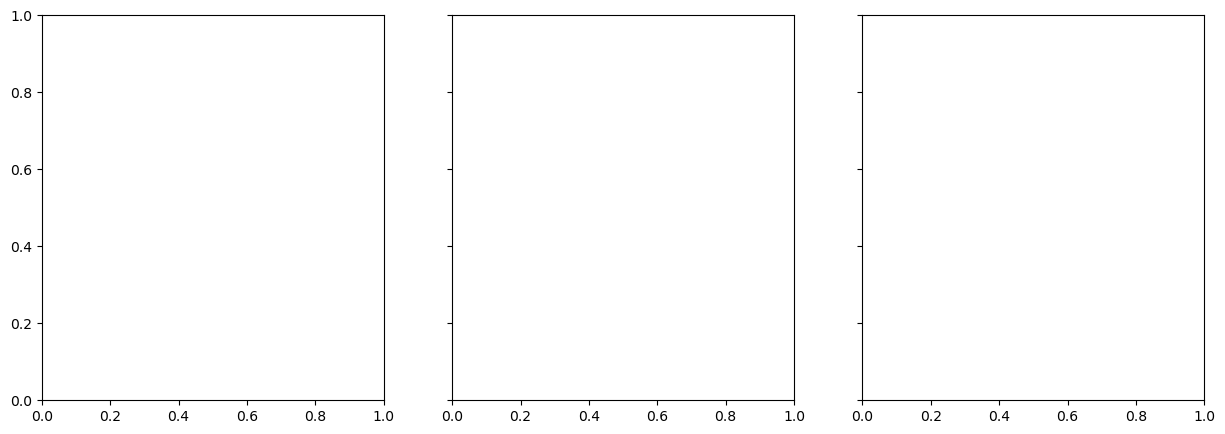

In [4]:
# Parameters
RANDOM_SEED = 42
SIM_TIME = 10000  # Simulation time in units
ARRIVAL_RATES = [0.5,0.6,0.7,0.8,0.9]  # ρ values
SERVICE_RATE = 1.0  # μ (service rate per server)
N_RUNS = 20  # Number of stochastic runs per configuration

# Stochastic simulation across multiple runs
def stochastic_simulation(n_servers, rho_values, n_runs, sim_time):
    results = {rho: [] for rho in rho_values}
    for rho in rho_values:
        # lambda = rho * n *  nu
        # nu = service capacity
        arrival_rate = rho * n_servers * SERVICE_RATE

        for _ in range(n_runs):
            avg_wait = simulate(n_servers, arrival_rate, sim_time, priority=False)
            results[rho].append(avg_wait)
    return results

# Main simulation and plotting
np.random.seed(RANDOM_SEED)
n_servers_list = [1, 2, 4]
fig, axes = plt.subplots(1, len(n_servers_list), figsize=(15, 5), sharey=True)
for i, n_servers in enumerate(n_servers_list):
    results = stochastic_simulation(n_servers, ARRIVAL_RATES, N_RUNS, SIM_TIME)
    conf95_list = []
    means_list = []
    
    # Plot results
    axes[i].set_title(f"n = {n_servers} Servers")
    for rho in ARRIVAL_RATES:
        avg_waits = results[rho]
        print(avg_waits)
        # axes[i].plot([rho] * len(avg_waits), avg_waits, 'o', label=f"ρ = {rho}")
        # Show mean and std deviation as a summary
        mean_wait = np.mean(avg_waits)
        std_wait = np.std(avg_waits)
        conf95 = 1.96 * std_wait / np.sqrt(N_RUNS)
        conf95_list.append(conf95)
        means_list.append(mean_wait)
        axes[i].errorbar(rho, mean_wait, yerr=std_wait, fmt='o', color='red')
    means_list = np.array(means_list)
    conf95_list = np.array(conf95_list)
    axes[i].fill_between(ARRIVAL_RATES, y1=(means_list - conf95_list), y2=(means_list + conf95_list), alpha=0.5, linewidth=0)
    axes[i].set_xlabel("ρ (Load Factor)")
    axes[i].set_ylabel("Avg Wait Time (Wq)")
    axes[i].grid(True)
    axes[i].legend()

plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.7031571477039785, 0.7678479020048138, 0.7458272488575897, 0.7749861345229351, 0.7027415220546545, 0.6645843480590349, 0.7716645421133812, 0.7041446712304255, 0.6880788661037033, 0.7688753417718988, 0.6928377495639925, 0.6952692682652695, 0.7020039974226527, 0.6821229520685992, 0.6964807680676083, 0.731489624740956, 0.6399484022494268, 0.6845332580235384, 0.7038928015280769, 0.6489978125104465]
[0.8790146013583209, 0.9249314084235143, 0.9934188598357933, 0.9804342174464555, 0.9404676653952188, 0.9392727500967001, 0.9766699644373946, 0.9989681519073645, 0.9060566970118157, 0.9830143673212924, 0.9912223062038445, 0.9567049220719569, 0.9384183847320848, 0.9866847640671135, 0.9660886674195838, 1.0912583670088272, 0.8834722947503668, 1.0436805102731082, 0.8690126284668022, 1.0061722738536798]
[1.215687003250244, 1.285300180582138, 1.1957194149364456, 1.4093470744696697, 1.2840823837291648, 1.3239972850549095, 1.4014268737526059, 1.3056668252330834, 1.3779178357872552, 1.1874916298591056, 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.2452712268990744, 0.23776343126529603, 0.2546702723364484, 0.23513987495163832, 0.2500248091300938, 0.2336491321180731, 0.23422298272764736, 0.2304945379751799, 0.2576115483678202, 0.24443316687065372, 0.28057060757662955, 0.25832812531824817, 0.2308659816378678, 0.23628010551692363, 0.23649286656416418, 0.2629823246644832, 0.23540391700945937, 0.22295024979805317, 0.23825831757318802, 0.250747939988627]
[0.3567574273630474, 0.3861522269202787, 0.3592634090829409, 0.391871939334368, 0.353210799447559, 0.3597080850673896, 0.3752451249882888, 0.37533680453961993, 0.35971487152080983, 0.3853305427765444, 0.3860658364576475, 0.37114366345697064, 0.39314378981351794, 0.40089052113119433, 0.38755646181602477, 0.34476879830848534, 0.370857236934156, 0.3817010373151702, 0.3850766298229086, 0.3898230139760275]
[0.5928032127485247, 0.523001192197773, 0.5646049815588527, 0.6244677304210143, 0.5362527818699909, 0.5344587332195581, 0.528236873614997, 0.5467767024448381, 0.594354534668224, 0.5821

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.06073098959570637, 0.062819298921088, 0.06582905570208851, 0.06623968596987155, 0.07016094849580667, 0.0706762594566141, 0.06817466433695793, 0.07065697105266851, 0.0664451463386329, 0.06363216235087096, 0.06819979003263589, 0.06888401497922624, 0.0657229855749576, 0.06825162975283917, 0.07616070638668412, 0.06898334523816656, 0.0686237990993965, 0.07241506559207629, 0.07092364561655387, 0.06919661853097368]
[0.14164470151506758, 0.12152083436373588, 0.11985726197335499, 0.129269251707459, 0.13696756119644846, 0.13371875574753056, 0.12362587987515257, 0.12389045339720764, 0.12543869393786408, 0.12351057015185903, 0.12947585293458616, 0.11663101025088832, 0.11818735119770084, 0.12237028283233993, 0.13080373890425864, 0.12221841540957333, 0.11241066692559326, 0.12217004350970144, 0.13404685547838932, 0.11557660350212995]
[0.2277270428679539, 0.21733401913465747, 0.22901234334080006, 0.23511273344152056, 0.22936196867485478, 0.2406582870794808, 0.2221346634557335, 0.2266566554344715, 0

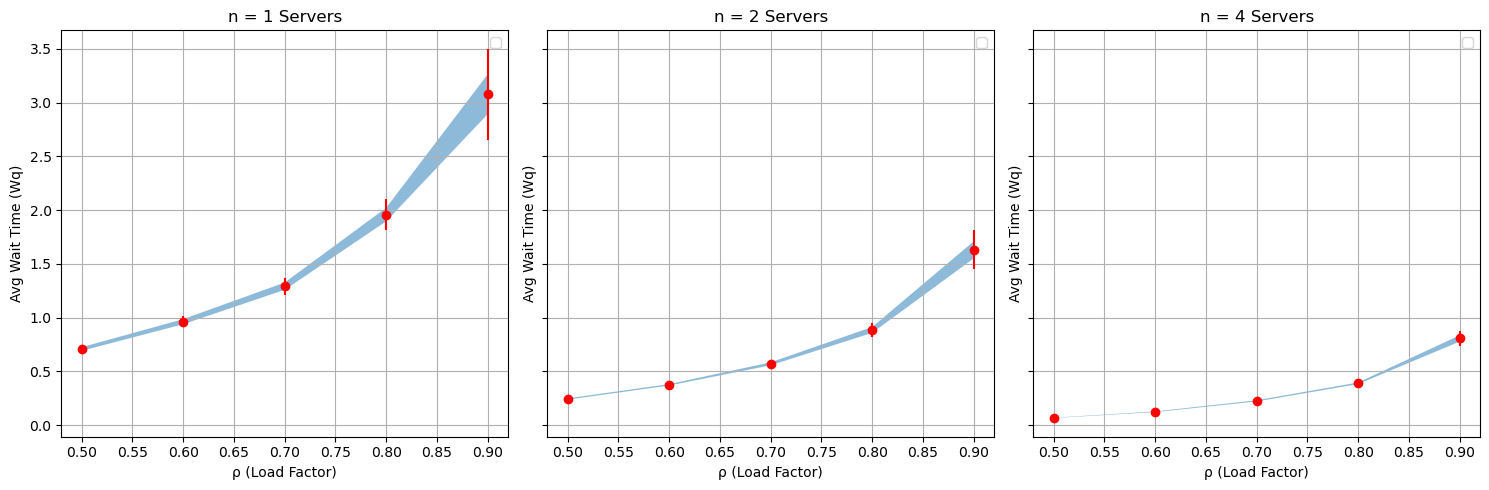

In [78]:
# Parameters
RANDOM_SEED = 42
SIM_TIME = 10000  # Simulation time in units
ARRIVAL_RATES = [0.5,0.6,0.7,0.8,0.9]  # ρ values
SERVICE_RATE = 1.0  # μ (service rate per server)
N_RUNS = 20  # Number of stochastic runs per configuration

# Stochastic simulation across multiple runs
def stochastic_simulation(n_servers, rho_values, n_runs, sim_time):
    results = {rho: [] for rho in rho_values}
    for rho in rho_values:
        # lambda = rho * n *  nu
        # nu = service capacity
        arrival_rate = rho * n_servers * SERVICE_RATE

        for _ in range(n_runs):
            avg_wait = simulate(n_servers, arrival_rate, sim_time, priority=True)
            results[rho].append(avg_wait)
    return results

# Main simulation and plotting
np.random.seed(RANDOM_SEED)
n_servers_list = [1, 2, 4]
fig, axes = plt.subplots(1, len(n_servers_list), figsize=(15, 5), sharey=True)
for i, n_servers in enumerate(n_servers_list):
    results = stochastic_simulation(n_servers, ARRIVAL_RATES, N_RUNS, SIM_TIME)
    conf95_list = []
    means_list = []
    
    # Plot results
    axes[i].set_title(f"n = {n_servers} Servers")
    for rho in ARRIVAL_RATES:
        avg_waits = results[rho]
        print(avg_waits)
        # axes[i].plot([rho] * len(avg_waits), avg_waits, 'o', label=f"ρ = {rho}")
        # Show mean and std deviation as a summary
        mean_wait = np.mean(avg_waits)
        std_wait = np.std(avg_waits)
        conf95 = 1.96 * std_wait / np.sqrt(N_RUNS)
        conf95_list.append(conf95)
        means_list.append(mean_wait)
        axes[i].errorbar(rho, mean_wait, yerr=std_wait, fmt='o', color='red')
    means_list = np.array(means_list)
    conf95_list = np.array(conf95_list)
    axes[i].fill_between(ARRIVAL_RATES, y1=(means_list - conf95_list), y2=(means_list + conf95_list), alpha=0.5, linewidth=0)
    axes[i].set_xlabel("ρ (Load Factor)")
    axes[i].set_ylabel("Avg Wait Time (Wq)")
    axes[i].grid(True)
    axes[i].legend()

plt.tight_layout()
plt.show()

In [72]:
def conduct_t_test(amount_runs=20):
    """
    This function conducts a t test for all combinations of n_servers and ρ values.
    It returns the results of the simulation and the t test.

    :param amount_runs: the amount of runs to conduct for each combination

    :return: results, t_test_results
    """
    # set the seed
    np.random.seed(RANDOM_SEED)

    results = {n: {p: [] for p in ARRIVAL_RATES} for n in n_servers_list}

    # conduct the simulations and save the results
    for n_servers in n_servers_list:
        for i, p in enumerate(ARRIVAL_RATES):
            # get the results for the first p
            for i in range(amount_runs):
                avg_wait = simulate(n_servers, p, SIM_TIME, priority=False)
                results[n_servers][p].append(avg_wait)

    t_test_results = {}
    # conduct the t tests
    for n1 in n_servers_list:
        for n2 in n_servers_list:
            if n1 != n2:
                for p in ARRIVAL_RATES:
                    t_stat, p_value = ttest_ind(results[n1][p], results[n2][p])
                    t_test_results[(n1, n2, p)] = (t_stat, p_value)
                    if p_value < 0.05:
                        print("Significant difference between n={} and n={} for ρ={} with a p_value of {}".format(n1, n2, p, p_value))

    return results, t_test_results

results, t_test_results = conduct_t_test(amount_runs=20)

Significant difference between n=1 and n=2 for ρ=0.1 with a p_value of 1.8917449998237873e-25
Significant difference between n=1 and n=2 for ρ=0.2 with a p_value of 7.493908591910764e-31
Significant difference between n=1 and n=2 for ρ=0.3 with a p_value of 2.1585452783290562e-36
Significant difference between n=1 and n=2 for ρ=0.4 with a p_value of 1.8231223310852366e-40
Significant difference between n=1 and n=2 for ρ=0.5 with a p_value of 4.186163112409681e-36
Significant difference between n=1 and n=2 for ρ=0.6 with a p_value of 6.184761793862073e-36
Significant difference between n=1 and n=2 for ρ=0.7 with a p_value of 2.267012088884869e-36
Significant difference between n=1 and n=2 for ρ=0.8 with a p_value of 4.5363862904124945e-31
Significant difference between n=1 and n=2 for ρ=0.9 with a p_value of 9.802716063883644e-25
Significant difference between n=1 and n=2 for ρ=1.0 with a p_value of 1.5682344038332995e-10
Significant difference between n=1 and n=4 for ρ=0.1 with a p_val

In [6]:
# Experiment with different service rate distributions

service_times = ['deterministic', 'exponential', 'hyperexponential']

def type_t_test(amount_runs=20):
    """
    This function conducts a t test for all combinations of service times at set n, rho = 0.9.
    It returns the results of the simulation and the t test.

    :param amount_runs: the amount of runs to conduct for each combination

    :return: results, t_test_results
    """
    # set the seed
    np.random.seed(RANDOM_SEED)

    results = {d: {n: [] for n in n_servers_list} for d in service_times}

    # conduct the simulations and save the results
    for n_servers in n_servers_list:
        for i, distib_type in enumerate(service_times):
            # get the results for the first p
            for i in range(amount_runs):
                avg_wait = simulate(n_servers, 0.9, SIM_TIME, priority=False, service_time_distribution= distib_type)
                results[distib_type][n_servers].append(avg_wait)

    t_test_results = {}
    # conduct the t tests
    for d1 in service_times:
        for d2 in service_times:
            if d1 != d2:
                for n in n_servers_list:
                    t_stat, p_value = ttest_ind(results[d1][n], results[d2][n])
                    t_test_results[(d1, d2, n)] = (t_stat, p_value)
                    if p_value < 0.05:
                        print("Significant difference between {} and {} for n={} with a p_value of {}".format(d1, d2, n, p_value))

    return results, t_test_results

results, t_test_results = type_t_test(amount_runs=20)

Significant difference between deterministic and exponential for n=1 with a p_value of 1.860239414892886e-11
Significant difference between deterministic and exponential for n=2 with a p_value of 1.0795776131785857e-28
Significant difference between deterministic and exponential for n=4 with a p_value of 1.0072170790351439e-10
Significant difference between deterministic and hyperexponential for n=1 with a p_value of 2.4319890180427597e-45
Significant difference between deterministic and hyperexponential for n=2 with a p_value of 3.740303228760345e-22
Significant difference between deterministic and hyperexponential for n=4 with a p_value of 6.543884161402983e-26
Significant difference between exponential and deterministic for n=1 with a p_value of 1.860239414892886e-11
Significant difference between exponential and deterministic for n=2 with a p_value of 1.0795776131785857e-28
Significant difference between exponential and deterministic for n=4 with a p_value of 1.0072170790351439e-10